Testing the renormalised Numerov method as described by Millard Alexander
on a two channel scattering calculation of an Cl atom colliding with H2.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import riccati_jn, riccati_yn

In [2]:
convE = 1./219474.6 # convert cminv to a.u.
convm = 1822.889    # convert atomic mass units to a.u.

## Potentials and couplings

In [3]:
def pot(r, l1, l2, l3, C1, C2, C3, C4):
    return C1*np.exp(-l1*r) + (C2+C3*r)*np.exp(-l2*r) - 0.5*C4*(np.tanh(1.2*(r-l3))+1)*r**(-6)

In [4]:
# setting up the grid:
N = 200
r = np.linspace(3.5, 22, N)
h = r[2] - r[1]
r = np.append(r, r[-1]+h)
print(h)

0.0929648241206027


In [5]:
A = 293.3 * convE # spin-orbit constant

Sigma = pot(r, 0.813, 1.2014, 5.5701,
            3.7457e+3*convE, 6.7280e+5*convE, -1.2773e+5*convE, 3.4733e+6*convE)

Pi = pot(r, 0.677, 2.2061, 6.2093,
         -7.7718e+3*convE, -7.3837e+7*convE, 3.2149e+7*convE, 2.9743e+6*convE)

V11 = 2./3.*Sigma + Pi/3. - A
V12 = np.sqrt(2.)/3.*(Pi - Sigma)
V21 = V12
V22 = Sigma/3. + 2./3.*Pi + 2.*A

#V = np.array([[V11, V12],[V21, V22]])
#V.shape
V = np.zeros((N+1, 2, 2))
for i in range(N+1):
    V[i] = np.array([[V11[i], V12[i]],[V21[i], V22[i]]])
print(V.shape)

(201, 2, 2)


In [6]:
# numerical eigenvalues
Ev = np.linalg.eigvalsh(V)
print(Ev.shape)

# analytical eigenvalues:
E1 = 0.5*(-np.sqrt(9.*A**2 + 2.*A*Pi - 2.*A*Sigma + Pi**2 - 2.*Pi*Sigma + Sigma**2) + A + Pi + Sigma)
E2 = 0.5*( np.sqrt(9.*A**2 + 2.*A*Pi - 2.*A*Sigma + Pi**2 - 2.*Pi*Sigma + Sigma**2) + A + Pi + Sigma)

(201, 2)


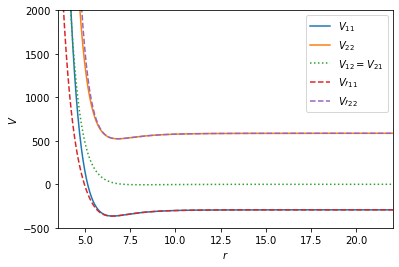

In [7]:
fig, ax = plt.subplots()
ax.plot(r, V[:,0,0]/convE, '-', label=r'$V_{11}$')
ax.plot(r, V[:,1,1]/convE, '-', label=r'$V_{22}$')
ax.plot(r, V[:,0,1]/convE, ':', label=r'$V_{12}=V_{21}$')
ax.plot(r, Ev[:,0]/convE, '--', label=r'$V\prime_{11}$')
ax.plot(r, Ev[:,1]/convE, '--', label=r'$V\prime_{22}$')
#ax.plot(r, E1/convE, 'k:')
#ax.plot(r, E2/convE, 'k:')
ax.set_xlim(3.5, 22.0)
ax.set_ylim(-500, 2000)
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$V$')
ax.legend()
plt.show()

## Numerov method

In [8]:
m = 2.85 * convm # mass of system

In [9]:
m

5195.23365

In [10]:
E = 1000 * convE # collision energy

In [11]:
E

0.0045563359040180496

In [12]:
Id = np.diag([1,1]) # Identity matrix

In [13]:
# functions for W, T and U matrices
w = lambda i: 2*m*(E*Id - V[i])
t = lambda i: -h**2/12. * w(i)
u = lambda i: 12.*np.linalg.inv(Id - t(i)) - 10.*Id  # Eq. (100)

In [14]:
# Numerov propagation
U = np.zeros((N, 2, 2))
T = np.zeros((N+1, 2, 2))
R = np.zeros((N+1, 2, 2))

U[0] = u(0)
R[1] = U[0]

U[1] = u(1)
R[2] = U[1] - np.linalg.inv(U[0])

for i in range(2, N+1):
    #print(i)
    U[i-1] = u(i-1)
    T[i] = t(i)
    R[i] = U[i-1] - np.linalg.inv(R[i-1])

In [15]:
E

0.0045563359040180496

## Determine the log derivative matrix

Can be calculated by Eq. (105)

Seems to match nearly with the values from M.A.'s script.

In [21]:
n = N-1 # because of zero indexing
Y_N = 1./h * (
     (0.5*Id-T[n+1]) @ np.linalg.inv(Id-T[n+1]) @ R[n+1]
    -(0.5*Id-T[n-1]) @ np.linalg.inv(Id-T[n-1]) @ np.linalg.inv(R[n])) @ (Id-T[n])

Y_N # log derivative matrix

array([[36.69283011, -0.71832009],
       [-0.71946462, -4.03952767]])

## Determine S matrix

### S matrix for l=0

The S matrix can be constructed by solving Eq. (109).


Seems also to match nearly with the values from the script.

In [22]:
k = np.sqrt(np.diag(2.*m*(E - V[n])))
h1 = np.diag(-1.j/np.sqrt(k) * np.exp(+1.j*k*r[n]))
h2 = h1.conj()
h1p = +1.j*np.diag(k) * h1
h2p = -1.j*np.diag(k) * h2

S = np.linalg.inv(h1p - Y_N @ h1) @ (h2p - Y_N @ h2)

S

array([[ 0.12690881-0.99120274j, -0.002956  +0.03742051j],
       [-0.00296071+0.03748014j, -0.0302924 +0.99883487j]])

In [23]:
# seems to be wrong compared to values from M.A.
#k1 = np.sqrt(2.*m*(E - E1[n+1]+E2[n+1]))
#k2 = np.sqrt(2.*m*(E - 0))

# this seems to give correct values
k1, k2 = np.sqrt(2.*m*(E - V[n])).diagonal()

In [24]:
h1_1 = -1.j/np.sqrt(k1) * np.exp(+1.j*k1*r[n])
h1_2 = -1.j/np.sqrt(k2) * np.exp(+1.j*k2*r[n])

h2_1 = +1.j/np.sqrt(k1) * np.exp(-1.j*k1*r[n])
h2_2 = +1.j/np.sqrt(k2) * np.exp(-1.j*k2*r[n])

h1 = np.diag([h1_1, h1_2])
h2 = np.diag([h2_1, h2_2])


h1p_1 = +k1/np.sqrt(k1) * np.exp(+1.j*k1*r[n])
h1p_2 = +k2/np.sqrt(k2) * np.exp(+1.j*k2*r[n])

h2p_1 = +k1/np.sqrt(k1) * np.exp(-1.j*k1*r[n])
h2p_2 = +k2/np.sqrt(k2) * np.exp(-1.j*k2*r[n])

h1p = np.diag([h1p_1, h1p_2])
h2p = np.diag([h2p_1, h2p_2])

In [25]:
S = np.linalg.inv(h1p - Y_N @ h1) @ (h2p - Y_N @ h2)

S # scattering matrix

array([[ 0.12690881-0.99120274j, -0.002956  +0.03742051j],
       [-0.00296071+0.03748014j, -0.0302924 +0.99883487j]])

The last version is taken from the Matlab script of M.A. about the method in the locally adiabatic basis.
This script is available here:
http://www2.chem.umd.edu/groups/alexander/teaching/matlab_files/renormalized_numerov_adiab_final.m

In [26]:
# taken from Matlab script of M.A.
k = np.sqrt(np.diag(-T[n+1]*12/(h*h))) # is not exactly the same as np.sqrt(np.diag(2.*m*(E - V[n])))
h2 = np.diag(1.j*np.exp(-k*1.j*r[n])/np.sqrt(k))
h2p=-1.j*np.diag(k)*h2
h1 = h2.conj()
h1p = 1.j*np.diag(k)*h1

S = np.linalg.inv(h1p - Y_N @ h1) @ (h2p - Y_N @ h2)
S

array([[ 0.12701157-0.99118958j, -0.00296147+0.03742007j],
       [-0.00296619+0.0374797j , -0.03048106+0.99882913j]])

### S matrix for arbitrary l

(following Roman Krems)

In [27]:
l1 = 0
l2 = 0

k1 = k[0]
k2 = k[1]

j1 = 1/np.sqrt(k1) * riccati_jn(l1, k1*r[n])[0]
j2 = 1/np.sqrt(k2) * riccati_jn(l2, k2*r[n])[0]

j1p = np.sqrt(k1) * riccati_jn(l1, k1*r[n])[1]
j2p = np.sqrt(k2) * riccati_jn(l2, k2*r[n])[1]

j = np.diagflat([j1, j2])
jp = np.diagflat([j1p, j2p])

In [28]:
y1 = 1/np.sqrt(k1) * riccati_yn(l1, k1*r[n])[0]
y2 = 1/np.sqrt(k2) * riccati_yn(l2, k2*r[n])[0]

y1p = np.sqrt(k1) * riccati_yn(l1, k1*r[n])[1]
y2p = np.sqrt(k2) * riccati_yn(l2, k2*r[n])[1]

y = np.diagflat([y1, y2])
yp = np.diagflat([y1p, y2p])

In [29]:
K = np.linalg.inv(Y_N @ y - yp) @ (Y_N @ j - jp)
K

array([[ 1.13553277, -0.03957659],
       [-0.03963965, -0.96917039]])

In [30]:
S = (Id + 1j*K) @ np.linalg.inv(Id - 1j*K)
S

array([[-0.12701157+0.99118958j,  0.00296147-0.03742007j],
       [ 0.00296619-0.0374797j ,  0.03048106-0.99882913j]])

In [31]:
S = np.linalg.inv(Id - 1j*K) @ (Id + 1j*K)
S

array([[-0.12701157+0.99118958j,  0.00296147-0.03742007j],
       [ 0.00296619-0.0374797j ,  0.03048106-0.99882913j]])

In [32]:
S = (Id - 1j*K) @ np.linalg.inv(Id + 1j*K)
S

array([[-0.12701157-0.99118958j,  0.00296147+0.03742007j],
       [ 0.00296619+0.0374797j ,  0.03048106+0.99882913j]])

Alternatively, real and imaginary part can be split:  
(Note: typo in Roman Krems book)

In [33]:
S = (Id - K@K) @ np.linalg.inv(Id + K@K) + 2j * K @ np.linalg.inv(Id + K@K)
S

array([[-0.12701157+0.99118958j,  0.00296147-0.03742007j],
       [ 0.00296619-0.0374797j ,  0.03048106-0.99882913j]])

Calculated in the way above, the S matrix has the opposite sign compared to the result of Millard Alexander.
If the Riccati-Bessel functions of the second kind are defined with the minus sign and the K matrix is calculated differently, the sign of the S matrix matches (s. below).

In [34]:
l1 = 0
l2 = 0
y1 = -1/np.sqrt(k1) * riccati_yn(l1, k1*r[n])[0]
y2 = -1/np.sqrt(k2) * riccati_yn(l2, k2*r[n])[0]
y1p = -np.sqrt(k1) * riccati_yn(l1, k1*r[n])[1]
y2p = -np.sqrt(k2) * riccati_yn(l2, k2*r[n])[1]
y = np.diagflat([y1, y2])
yp = np.diagflat([y1p, y2p])


K = np.linalg.inv(Y_N @ j - jp) @ (Y_N @ y - yp)
print(K)

S = (Id + 1j*K) @ np.linalg.inv(Id - 1j*K)
print(S)

[[-0.87939032  0.03591037]
 [ 0.03596759  1.03034155]]
[[ 0.12701157-0.99118958j -0.00296147+0.03742007j]
 [-0.00296619+0.0374797j  -0.03048106+0.99882913j]]
